In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [3]:
from scipy.signal import savgol_filter

from common import combine_csvs

In [337]:
DOWN = '*down.csv'
UP = '*up.csv'
N_TYPE = 'Type'
N_REGIONS = 'region'
N_TIMESTAMP = 'timestamp'
N_TRANSF_TIME = 'Transfer Time (s)'
N_DATA_SIZES = 'Data Sizes'

REGION_MAP = {'af-south-1':'Africa Cape Town', 'ap-south-1':'Asia Pacific Mumbai', 'ap-southeast-1':'Asia Pacific Singapore', 'ap-southeast-2':'Asia Pacific Sydney',
                  'ap-northeast-1':'Asia Pacific Tokyo', 'eu-west-2':'Europe London', 'me-south-1':'Middle East Bahrain', 'sa-east-1':'South America Sao Paulo', 
              'us-west-1':'US West N. California'}

In [6]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [11]:
from ipyfilechooser import FileChooser

# Create and display a FileChooser widget
fc = FileChooser('data/Home_network_data/SCP/')
fc.sandbox_path = 'data/Home_network_data/SCP/'
display(fc)

FileChooser(path='/home/sami/starlink-plot/data/Home_network_data/SCP', filename='', title='', show_hidden=Fal…

In [12]:
fc1 = FileChooser('data/starlink-data/SCP/')
fc1.sandbox_path = 'data/starlink-data/SCP/'
display(fc1)

FileChooser(path='/home/sami/starlink-plot/data/starlink-data/SCP', filename='', title='', show_hidden=False, …

In [144]:
#src_dirs = [('Starlink', 'data/Starlink_csv_2022_04-07_to_04-12/')]
#src_dirs = [('Home', 'data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/')]
src_dirs = []
if fc1.selected_path:
    src_dirs.append(('Starlink', fc1.selected_path))
if fc.selected_path:
    src_dirs.append(('Home', fc.selected_path))
src_dirs

[('Starlink',
  '/home/sami/starlink-plot/data/starlink-data/SCP/2022-06-06_starlink_measures_scp'),
 ('Home',
  '/home/sami/starlink-plot/data/Home_network_data/SCP/2022-06-06_trad_measures_scp')]

In [380]:
pattern = DOWN
df = pd.DataFrame()
for type_name, folder in src_dirs:
    files = glob.glob(f"{folder}/**/{pattern}", recursive=True)
    df_temp = pd.concat([pd.read_csv(f, index_col=False) for f in files])
    df_temp.timestamp = pd.to_datetime(df_temp.timestamp, unit='s')
    
    df_temp[N_TYPE] = type_name
    if not df.empty:
        df = df.merge(df_temp, how='outer')
    else:
        df = df_temp
df.dropna(how='all', inplace=True)
df[N_REGIONS] = df[N_REGIONS].map(REGION_MAP)
df

,timestamp,region,1MB,10MB,100MB,200MB,300MB,Type
0,2022-06-06 14:18:20,South America Sao Paulo,4.872,6.451,58.193,30.542,103.675,Starlink
1,2022-06-06 17:41:14,South America Sao Paulo,5.267,18.876,17.465,32.072,69.107,Starlink
2,2022-06-06 21:38:09,South America Sao Paulo,5.261,5.939,17.086,30.399,59.845,Starlink
3,2022-06-07 01:45:05,South America Sao Paulo,5.187,19.880,17.177,158.127,403.818,Starlink
4,2022-06-07 06:29:19,South America Sao Paulo,5.099,6.411,26.132,45.788,216.885,Starlink
...,...,...,...,...,...,...,...,...
318,2022-06-08 03:08:34,Asia Pacific Mumbai,5.727,7.267,19.607,33.490,47.050,Home
319,2022-06-08 07:08:13,Asia Pacific Mumbai,5.823,7.283,19.534,33.099,46.455,Home
320,2022-06-08 11:12:23,Asia Pacific Mumbai,5.727,7.135,19.171,33.125,46.510,Home
321,2022-06-08 15:09:25,Asia Pacific Mumbai,6.161,7.209,19.677,33.168,46.894,Home


In [381]:
# Filter out outliers
df_no_out = df.copy()
#df_no_out[df[N_TYPE] == 'Home'].loc[:,2:7] = df[df[N_TYPE] == 'Home'].iloc[:,2:7] < 200
df_no_out = df_no_out.set_index([N_TYPE, N_REGIONS, N_TIMESTAMP])
df_no_out.loc['Home'] = df_no_out[df_no_out.loc['Home'] < 200]
df_no_out.reset_index(inplace=True)
df_no_out

,Type,region,timestamp,1MB,10MB,100MB,200MB,300MB
0,Starlink,South America Sao Paulo,2022-06-06 14:18:20,4.872,6.451,58.193,30.542,103.675
1,Starlink,South America Sao Paulo,2022-06-06 17:41:14,5.267,18.876,17.465,32.072,69.107
2,Starlink,South America Sao Paulo,2022-06-06 21:38:09,5.261,5.939,17.086,30.399,59.845
3,Starlink,South America Sao Paulo,2022-06-07 01:45:05,5.187,19.880,17.177,158.127,403.818
4,Starlink,South America Sao Paulo,2022-06-07 06:29:19,5.099,6.411,26.132,45.788,216.885
...,...,...,...,...,...,...,...,...
318,Home,Asia Pacific Mumbai,2022-06-08 03:08:34,5.727,7.267,19.607,33.490,47.050
319,Home,Asia Pacific Mumbai,2022-06-08 07:08:13,5.823,7.283,19.534,33.099,46.455
320,Home,Asia Pacific Mumbai,2022-06-08 11:12:23,5.727,7.135,19.171,33.125,46.510
321,Home,Asia Pacific Mumbai,2022-06-08 15:09:25,6.161,7.209,19.677,33.168,46.894


In [388]:
# Aggreagation options
df_no_out.to_csv("output/SCP/out_scp_before.csv", encoding='utf-8-sig')
df_regs_interp = df.set_index(N_TIMESTAMP)
df_regs_interp = df_regs_interp.groupby([N_TYPE, N_REGIONS]).resample('H').mean()
#df_regs_interp = df_regs_interp.set_index([N_TYPE, N_REGIONS, N_TIMESTAMP])
df_regs_interp = df_regs_interp.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,11,1))
df_regs_interp = df_regs_interp.reset_index()

df_regs_interp

,Type,region,timestamp,1MB,10MB,100MB,200MB,300MB
0,Home,Africa Cape Town,2022-06-06 12:00:00,6.355000,7.750000,21.152000,36.022000,51.070000
1,Home,Africa Cape Town,2022-06-06 13:00:00,6.338000,7.733000,21.173000,35.984667,51.767333
2,Home,Africa Cape Town,2022-06-06 14:00:00,6.321000,7.716000,21.194000,35.947333,52.464667
3,Home,Africa Cape Town,2022-06-06 15:00:00,6.304000,7.699000,21.215000,35.910000,53.162000
4,Home,Africa Cape Town,2022-06-06 16:00:00,6.284500,7.681500,21.257250,36.001250,52.630250
...,...,...,...,...,...,...,...,...
1199,Starlink,US West N. California,2022-06-09 15:00:00,1.955333,3.573667,9.718667,17.839667,25.179333
1200,Starlink,US West N. California,2022-06-09 16:00:00,1.846000,2.645000,11.384000,17.375000,28.149000
1201,Starlink,US West N. California,2022-06-09 17:00:00,1.859000,3.407333,11.545000,21.692333,31.325667
1202,Starlink,US West N. California,2022-06-09 18:00:00,1.872000,4.169667,11.706000,26.009667,34.502333


In [389]:
df_unstacked = df_regs_interp.melt(id_vars=[N_REGIONS, N_TYPE, N_TIMESTAMP], value_vars=['1MB', '10MB', '100MB', '200MB', '300MB'],
                      var_name=N_DATA_SIZES, value_name=N_TRANSF_TIME)
#df_unstacked.sort_values(N_TIMESTAMP).to_csv('output/SCP/out_scp.csv')
df_unstacked

,region,Type,timestamp,Data Sizes,Transfer Time (s)
0,Africa Cape Town,Home,2022-06-06 12:00:00,1MB,6.355000
1,Africa Cape Town,Home,2022-06-06 13:00:00,1MB,6.338000
2,Africa Cape Town,Home,2022-06-06 14:00:00,1MB,6.321000
3,Africa Cape Town,Home,2022-06-06 15:00:00,1MB,6.304000
4,Africa Cape Town,Home,2022-06-06 16:00:00,1MB,6.284500
...,...,...,...,...,...
6015,US West N. California,Starlink,2022-06-09 15:00:00,300MB,25.179333
6016,US West N. California,Starlink,2022-06-09 16:00:00,300MB,28.149000
6017,US West N. California,Starlink,2022-06-09 17:00:00,300MB,31.325667
6018,US West N. California,Starlink,2022-06-09 18:00:00,300MB,34.502333


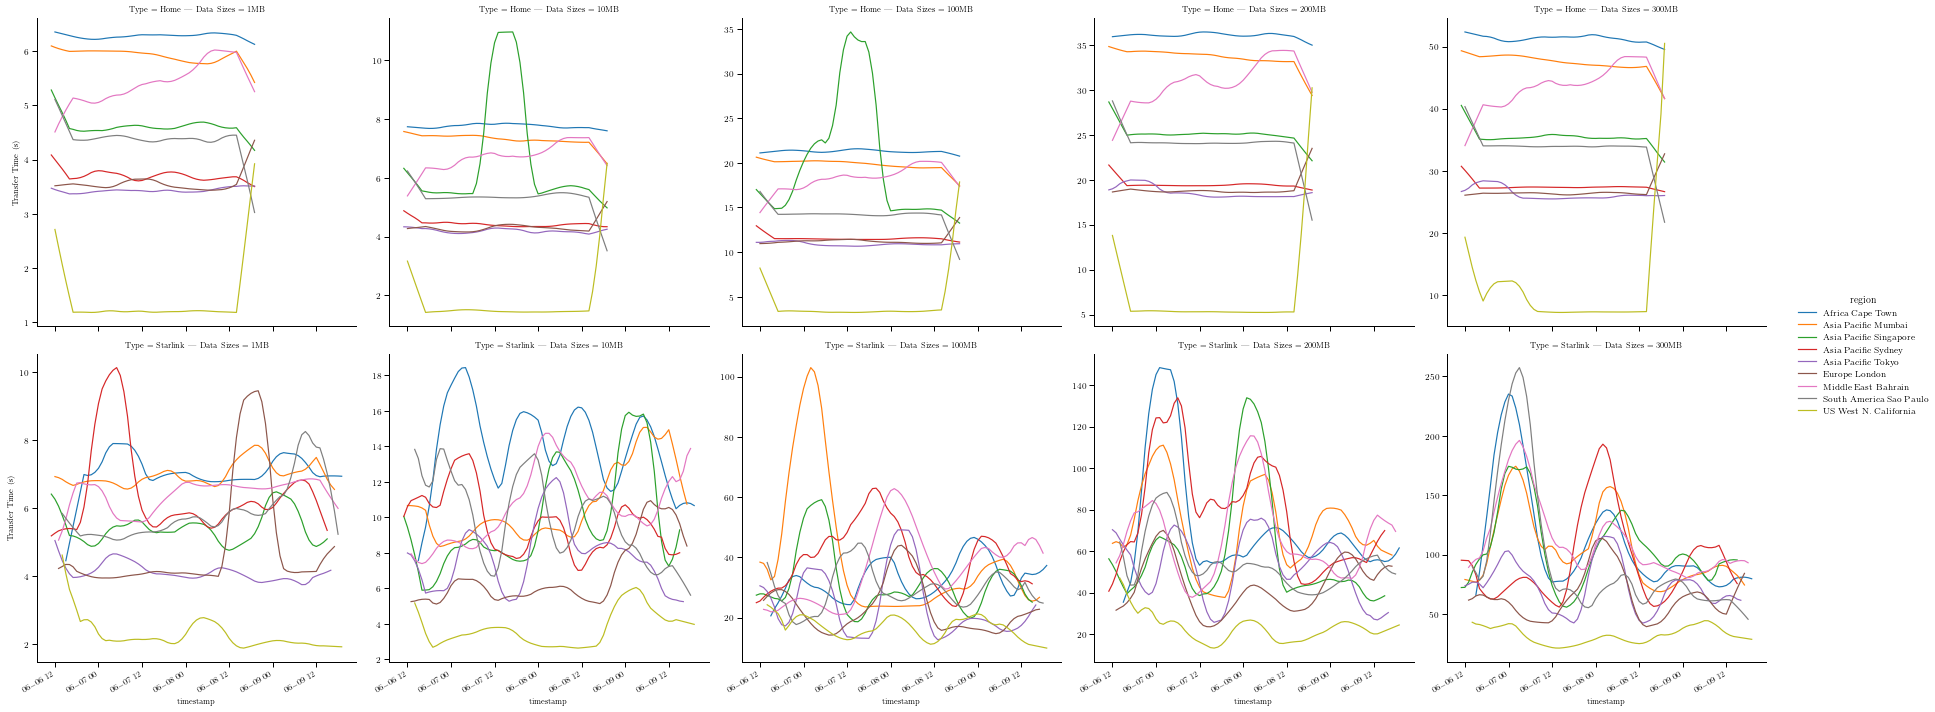

In [387]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

#g = sns.lineplot(data=df_unstacked, x=N_TIMESTAMP, y=N_TRANSF_TIME, hue=N_REGIONS, style=N_DATA_SIZES)
g = sns.FacetGrid(data=df_unstacked, col=N_DATA_SIZES, row=N_TYPE, hue=N_REGIONS, sharey=False, height=5)
g.map(sns.lineplot, N_TIMESTAMP, N_TRANSF_TIME)
#g = sfigurelineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')
g.figure.autofmt_xdate()
g.add_legend()
g.tight_layout()

#fig.tight_layout()

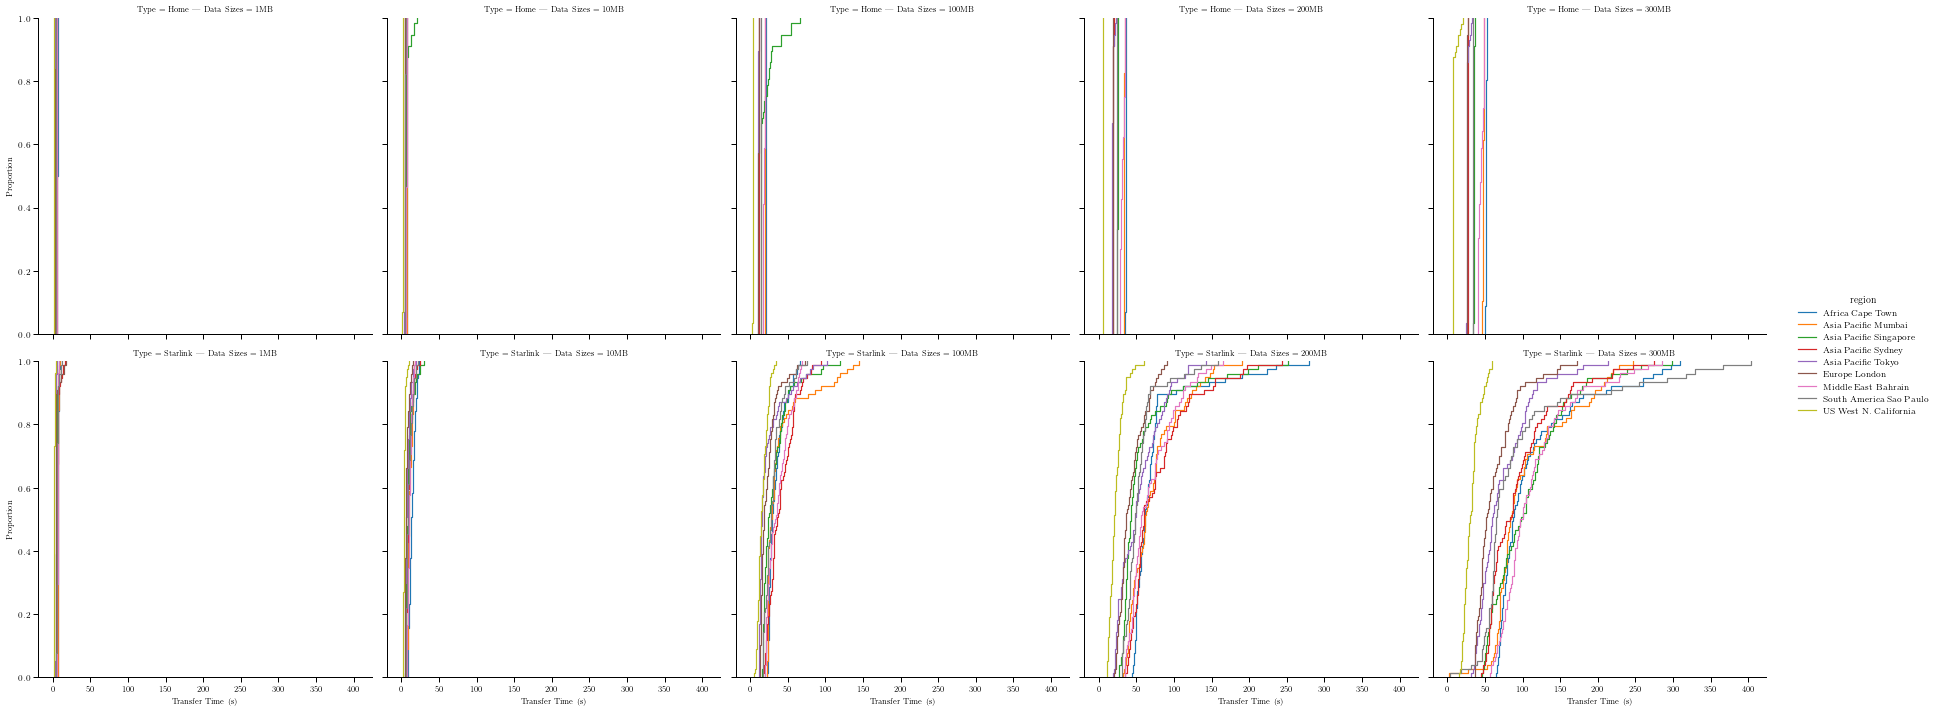

In [393]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, col=N_DATA_SIZES, row=N_TYPE, hue=N_REGIONS, height=5)
g2.map(sns.ecdfplot, N_TRANSF_TIME)
g2.add_legend()
#sns.ecdfplot(data=df_unstacked, x='bandwidth', hue=N_REGIONS)
g2.tight_layout()
#fig2.tight_layout()

In [391]:
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')
g.savefig(f'output/SCP/scp.pdf', bbox_inches='tight')
g2.savefig(f'output/SCP/scp_cdf.pdf', bbox_inches='tight')